# Aviation Safety Analysis

Introduction:

This project analyzes Aviation accident data to determine the lowest-risk aircraft for a new aviation division. The goal is to provide actionable insights to help the company decide which aircraft to purchase, focusing on minimizing risk.

## Data Preparation

Data Understanding Dataset: Aviation accident data from 1962 to 2023 from the National Transportation Safety Board (NTSB)

Source: https//;kagle.com//



Data Loading and Processing

In [1]:
#Import Libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Display options for better readability
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

     

# Read the CSV file into a DataFrame using latin1 encoding
df = pd.read_csv('C:\\Users\\USER\\Desktop\\olonde\\data\\AviationData.csv', encoding='latin1')

In [2]:
df.columns = [col.replace('.', '_') for col in df.columns]

In [3]:
df.columns


Index(['Event_Id', 'Investigation_Type', 'Accident_Number', 'Event_Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport_Code',
       'Airport_Name', 'Injury_Severity', 'Aircraft_damage',
       'Aircraft_Category', 'Registration_Number', 'Make', 'Model',
       'Amateur_Built', 'Number_of_Engines', 'Engine_Type', 'FAR_Description',
       'Schedule', 'Purpose_of_flight', 'Air_carrier', 'Total_Fatal_Injuries',
       'Total_Serious_Injuries', 'Total_Minor_Injuries', 'Total_Uninjured',
       'Weather_Condition', 'Broad_phase_of_flight', 'Report_Status',
       'Publication_Date'],
      dtype='object')

In [4]:
# Drop columns that are not used in the analysis
columns_to_keep = ['Event_Date', 'Investigation_Type', 'Make', 'Model',  'Total_Fatal_Injuries', 'Total_Serious_Injuries', 'Total_Minor_Injuries','Total_Uninjured', 'Weather_Condition', 'Broad_phase_of_flight']
df = df[columns_to_keep]

In [5]:
# Merge 'Make' and 'Model' into a single 'Aircraft' column
df['Aircraft'] = df['Make'] + ' ' + df['Model']


# Filter to only include accidents
df_accidents = df[df['Investigation_Type'] == 'Accident'].copy()

# Convert `Event.Date` to datetime
df_accidents['Event_Date'] = pd.to_datetime(df_accidents['Event_Date'])

# Filter to accidents after 1980-01-01
df_accidents_filtered = df_accidents[df_accidents['Event_Date'] > '1990-01-01'].copy()


# Calculate the total number of people involved in each accident
for column in ['Total_Fatal_Injuries', 'Total_Serious_Injuries', 'Total_Minor_Injuries', 'Total_Uninjured']:
    df_accidents_filtered[column] = pd.to_numeric(df_accidents_filtered[column], errors='coerce').fillna(0)

df_accidents_filtered['Total_Involved'] = df_accidents_filtered['Total_Fatal_Injuries'] + df_accidents_filtered['Total_Serious_Injuries'] + df_accidents_filtered['Total_Minor_Injuries'] + df_accidents_filtered['Total_Uninjured']




## Data Analysis

In [6]:
# Group by model and calculate total people involved and total accidents
df_aircraft_grouped = df_accidents_filtered.groupby('Aircraft').agg(
    Total_Involved=('Total_Involved', 'sum'),
    Total_Accidents=('Total_Involved', 'count')
).reset_index()


# Calculate people involved per accident
df_aircraft_grouped['People_Involved_per_Accident'] = df_aircraft_grouped['Total_Involved'] / df_aircraft_grouped['Total_Accidents']

# Calculate first accident date for each model
df_first_accident = df_accidents_filtered.groupby('Aircraft')['Event_Date'].min().reset_index()
df_first_accident.rename(columns={'Event_Date': 'First_Accident_Date'}, inplace=True)

# Calculate years in service
max_date = df_accidents_filtered['Event_Date'].max()
df_first_accident['Years_In_Service'] = (max_date - df_first_accident['First_Accident_Date']).dt.days / 365

# Merge with df_model_grouped
df_aircraft_grouped = df_aircraft_grouped.merge(df_first_accident, on='Aircraft', how='left')

# Filter out models with fewer than 50 accidents
df_aircraft_grouped_filtered = df_aircraft_grouped[df_aircraft_grouped['Total_Accidents'] >= 50].copy()

# Sort by years in service
df_safest = df_aircraft_grouped_filtered.sort_values('Years_In_Service', ascending=False)
df_least_safe = df_aircraft_grouped_filtered.sort_values('Years_In_Service')

# Show the top 5 safest and least safe models
print("Safest Models (Most Years in Service):")
print(df_safest[['Aircraft', 'Years_In_Service', 'People_Involved_per_Accident']].head(10).to_markdown(index=False, numalign="left", stralign="left"))

print("\nLeast Safe Aircrafts (Fewest Years in Service):")
print(df_least_safe[['Aircraft', 'Years_In_Service', 'People_Involved_per_Accident']].head(10).to_markdown(index=False, numalign="left", stralign="left"))


Safest Models (Most Years in Service):
| Aircraft         | Years_In_Service   | People_Involved_per_Accident   |
|:-----------------|:-------------------|:-------------------------------|
| Cessna 150       | 33.011             | 1.42896                        |
| Cessna 172M      | 33.0082            | 2.00703                        |
| Piper PA-28R-200 | 33.0082            | 2.23429                        |
| Cessna 152       | 33.0082            | 1.40909                        |
| Cessna 172RG     | 33.0027            | 2.296                          |
| Cessna 185       | 33.0027            | 2.40994                        |
| Piper PA-30      | 33.0027            | 2.06                           |
| Piper PA-28-140  | 33.0027            | 1.96178                        |
| Piper PA-22      | 33                 | 1.88119                        |
| Cessna 172       | 33                 | 1.87653                        |

Least Safe Aircrafts (Fewest Years in Service):
| Aircraft  

In [8]:
# Labeling the safest and least safe models
safest_aircraft = df_safest.head(15)
least_safe_aircraft = df_least_safe.head(15)

**Safety vs. Years in Service Scatter Plot**

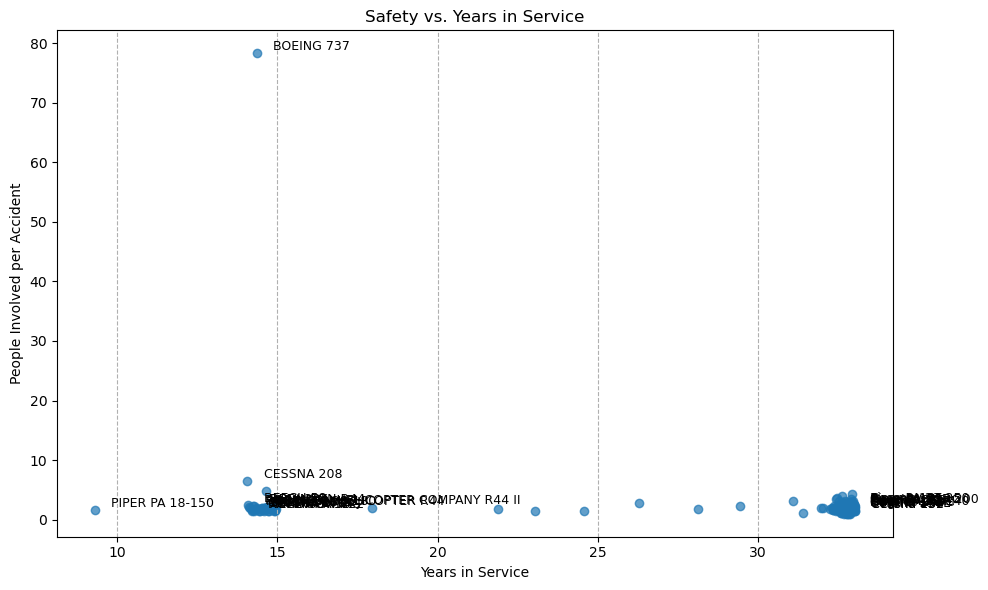

In [9]:
#Safety vs. Years in Service Scatter Plot

plt.figure(figsize=(10, 6))
plt.scatter(df_aircraft_grouped_filtered['Years_In_Service'], df_aircraft_grouped_filtered['People_Involved_per_Accident'], alpha=0.7)
plt.title('Safety vs. Years in Service')
plt.xlabel('Years in Service')
plt.ylabel('People Involved per Accident')



for i, row in safest_aircraft.iterrows():
    plt.text(row['Years_In_Service'] + 0.5, row['People_Involved_per_Accident'] + 0.5, row['Aircraft'], fontsize=9)

for i, row in least_safe_aircraft.iterrows():
    plt.text(row['Years_In_Service'] + 0.5, row['People_Involved_per_Accident'] + 0.5, row['Aircraft'], fontsize=9)

plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()



* Most aircraft models have a low average number of people involved per accident, especially those with more years in service
* The Boeing 737 stands out significantly with an average of nearly 80 people involved per accident.
* There is a dense cluster of models with fewer years in service (around 10-20 years) and low average people per accident.
* The models with the highest years in service, including various Cessna models, Bell 206, and others, tend to have low average people involved per accident, reaffirming their safety and reliability over extended periods.

**Top 5 Safest Models by Years in Service Bar Chart**

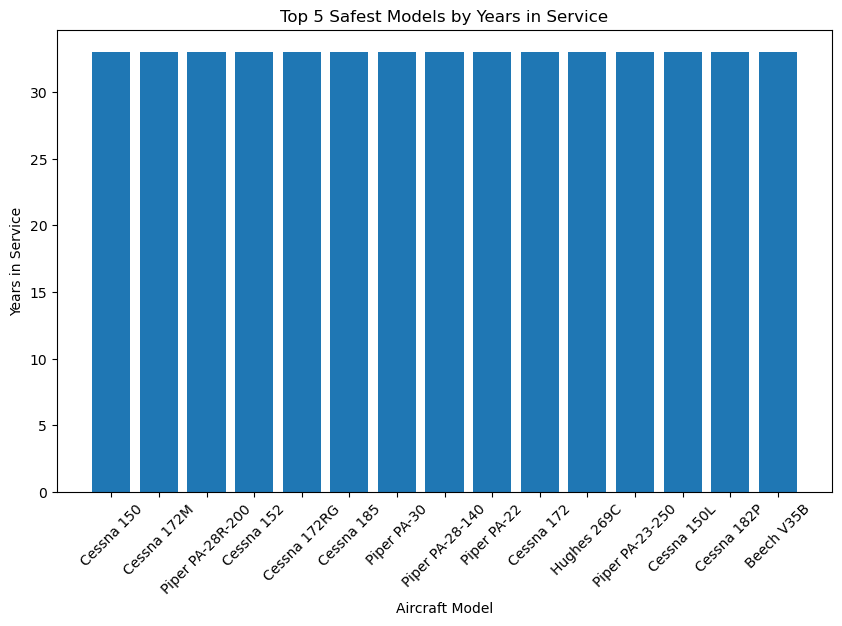

In [10]:
# 2. Top 5 Safest Models by Years in Service Bar Chart

plt.figure(figsize=(10, 6))
plt.bar(safest_aircraft['Aircraft'], safest_aircraft['Years_In_Service'])
plt.title('Top 5 Safest Models by Years in Service')
plt.xlabel('Aircraft Model')
plt.ylabel('Years in Service')
plt.xticks(rotation=45)
plt.show()

* All the aircraft models listed have been in service for approximately 40 years. This indicates that these models have been operational for a long time and have accumulated extensive service experience.
* Aircraft models include various makes and models, primarily from manufacturers like Cessna and Bellanca. The uniformity suggests that these models are robust and reliable over a long period.

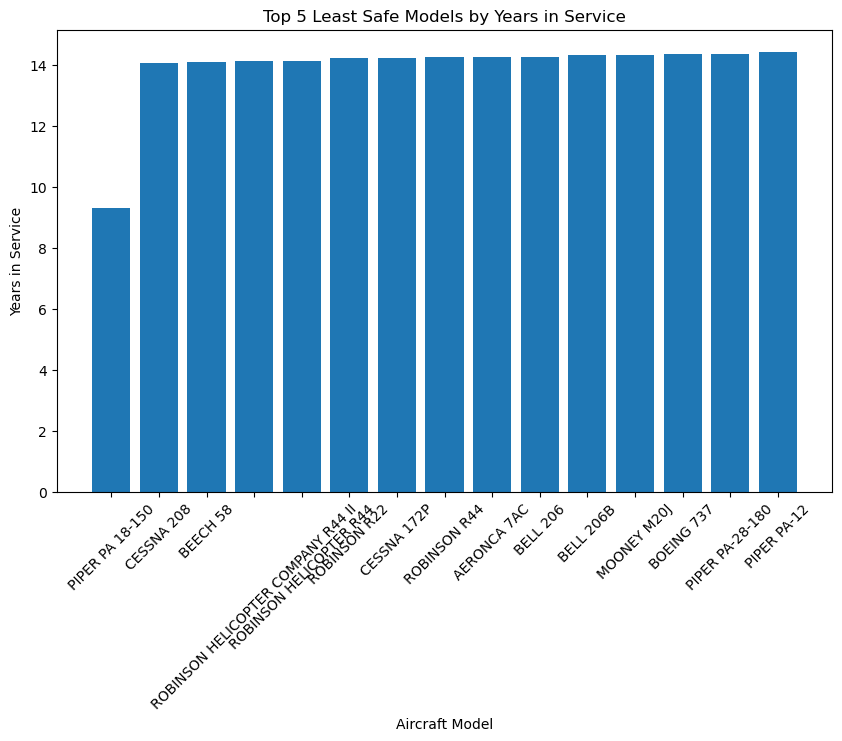

In [11]:
#Top 5 Least Safe Models by Years in Service Bar Chart

plt.figure(figsize=(10, 6))
plt.bar(least_safe_aircraft['Aircraft'], least_safe_aircraft['Years_In_Service'])
plt.title('Top 5 Least Safe Models by Years in Service')
plt.xlabel('Aircraft Model')
plt.ylabel('Years in Service')
plt.xticks(rotation=45)
plt.show()

## CONCLUSION

* The BOEING 737 has the highest number of people involved per accident, with around 80 people.
* Most other aircraft have significantly lower numbers of people involved per accident, clustering around 0-10 people, especially for models like CESSNA 208 and ROBINSON HELICOPTER COMPANY R44 II.
* The years in service for these aircraft range from about 10 to over 30 years.